## Pré-processamento

Na fase de criação do dataset uma parte do pré-processamento já foi feita, foi o passo de transformar todas as letras em minúsculas. Na fase atual, inicialmente, tivemos a ideia de remover as stopwords que englobam conectivos como conjunções (e, como, ou, ...). Caso fossem removidas os versos poderiam ficar sem muito significado. 

Referências: 
 - https://keras.io/examples/lstm_text_generation/
 - https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

%matplotlib inline

In [16]:
# Importação dos dados
dataset = pd.read_csv('musics.csv', encoding = "utf-8")
dataset

,artist,track,music
0,Djavan,Flor de Lis,"valei-me, deus!\né o fim do nosso amor\nperdoa..."
1,Gilberto Gil,Refavela,"aiaiá, kiriê \nkiriê, iaiá \n\na refavela \nre..."
2,Caetano Veloso,Reconvexo - Ao Vivo,eu sou o vento que lança a areia do saara\nsob...
3,Cássia Eller,Relicário - Ao Vivo,é uma índia com colar\na tarde linda que não q...
4,Elis Regina,Como Nossos Pais,não quero lhe falar meu grande amor \ndas cois...
5,Geraldo Azevedo,Dia Branco - Ao Vivo | Bonus Track,se você vier pro que der e vier comigo\neu lhe...
6,Adriana Calcanhotto,Devolva-Me (Ao Vivo),rasgue as minhas cartas\ne não me procure mais...
7,João Gilberto,Chega de Saudade,vai minha tristeza e diz a ela que\nsem ela nã...
8,Chico Buarque,Futuros Amantes,"não se afobe, não\nque nada é pra já \no amor ..."
9,Ney Matogrosso,Sorte,tudo de bom que você me fizer\nfaz minha rima ...


## Wordcloud

Visualização das palavras que mais se repetem do dataset importado. É claro que conjunções e pronomes são mais utilizados, talvez até poluam o dataset, mas sem estas palavras o sentido dos versos/frases estará comprometido e por isso não serão removidas.

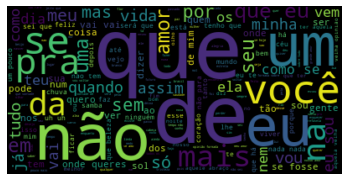

In [17]:
musics = ''.join(dataset['music'])
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color="black").generate(musics)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vetorização dos textos


Referências:
- https://stackabuse.com/python-for-nlp-deep-learning-text-generation-with-keras/

Mapeando caracteres para char e chars para caracteres.


In [19]:
chars = sorted(list(set(musics)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))

In [20]:
n_chars = len(musics)
n_vocab = len(chars)

In [21]:
seq_len = 100
data_X = []
data_y = []
for i in range(0, n_chars - seq_len, 1):
    seq_in  = musics[i:i+seq_len]
    seq_out = musics[i + seq_len]
    data_X.append([chars_int[char] for char in seq_in])
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)

In [23]:
X = np.reshape(data_X, (n_patterns, seq_len, 1))
X = X/float(n_vocab)
#Hot encode
y = np_utils.to_categorical(data_y)

In [26]:
# Building model
LSTM_layer_num = 4;
layer_size = [256, 256, 256, 256]

model = Sequential()
model.add(GRU(layer_size[0], input_shape=(X.shape[1], X.shape[2]), return_sequences=True))

for i in range(1, LSTM_layer_num):
    model.add(GRU(layer_size[i], return_sequences=True))

In [27]:
model.add(Flatten())
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 100, 256)          198144    
_________________________________________________________________
gru_10 (GRU)                 (None, 100, 256)          393984    
_________________________________________________________________
gru_11 (GRU)                 (None, 100, 256)          393984    
_________________________________________________________________
gru_12 (GRU)                 (None, 100, 256)          393984    
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 63)                1612863   
_________________________________________________________________
activation_3 (Activation)    (None, 63)               

In [30]:
checkpoint_name = 'Weights-GRU-improvement-{epoch:03d}-{loss:.5f}-bigger.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose=1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

In [33]:
# Training

model_params = {
    'epochs': 1,
    'batch_size': 128,
    'callbacks': callbacks_list,
    'verbose': 1,
    'validation_split': 0.2,
    'validation_data': None,
    'shuffle': True,
    'initial_epoch': 0,
    'steps_per_epoch': None,
    'validation_steps': None
    }

model.fit(X, 
          y,
          epochs = model_params['epochs'],
          batch_size= model_params['batch_size'],
          callbacks = model_params['callbacks'],
          verbose = model_params['verbose'],
          validation_split = model_params['validation_split'],
          validation_data = model_params['validation_data'],
          shuffle = model_params['shuffle'],
          initial_epoch = model_params['initial_epoch'],
          steps_per_epoch = model_params['steps_per_epoch'],
          validation_steps = model_params['validation_steps']
            )

Train on 38992 samples, validate on 9748 samples
Epoch 1/10
 3840/38992 [=>............................] - ETA: 1:16:28 - loss: 3.1830

KeyboardInterrupt: 